In [ ]:

import tensorflow as tf### models
import pandas as pd ### reading and processing data
import seaborn as sns ### visualization
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
from tensorflow.keras.layers import Normalization, Dense, InputLayer
from tensorflow.keras.losses import MeanSquaredError, Huber, MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

2024-05-22 14:37:09.607922: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-22 14:37:09.608089: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-22 14:37:09.779137: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/second-hand-used-cars-data-set-linear-regression/train.csv


In [ ]:
data = pd.read_csv("train.csv", sep= ",")
data.head()

,v.id,on road old,on road now,years,km,rating,condition,economy,top speed,hp,torque,current price
0,1,535651,798186,3,78945,1,2,14,177,73,123,351318.0
1,2,591911,861056,6,117220,5,9,9,148,74,95,285001.5
2,3,686990,770762,2,132538,2,8,15,181,53,97,215386.0
3,4,573999,722381,4,101065,4,3,11,197,54,116,244295.5
4,5,691388,811335,6,61559,3,9,12,160,53,105,531114.5


# Data Preparation

In [ ]:
data.shape

(1000, 12)

In [ ]:
columns_to_plot = ['v.id', 'on road old', 'on road now', 'years', 'km', 'rating', 'condition', 'economy', 'top speed', 'hp', 'torque', 'current price']
sns.pairplot(data[columns_to_plot], diag_kind='kde')

In [ ]:
tensor_data = tf.random.shuffle(tf.cast(tf.constant(data),tf.float32))
tensor_data = tf.constant(data)
tensor_data = tf.cast(tensor_data,tf.float32)
tensor_data = tf.random.shuffle(tensor_data)
print(tensor_data)

tf.Tensor(
[[4.020000e+02 5.860190e+05 8.080680e+05 ... 8.200000e+01 8.300000e+01
  1.441915e+05]
 [1.020000e+02 6.987480e+05 8.378280e+05 ... 7.900000e+01 1.110000e+02
  3.572940e+05]
 [8.140000e+02 5.868660e+05 8.975710e+05 ... 5.100000e+01 9.900000e+01
  4.574630e+05]
 ...
 [5.180000e+02 5.201680e+05 8.969830e+05 ... 7.600000e+01 1.330000e+02
  1.111850e+05]
 [8.800000e+02 5.381920e+05 8.108620e+05 ... 1.110000e+02 1.050000e+02
  2.615680e+05]
 [3.920000e+02 5.839790e+05 7.118200e+05 ... 6.800000e+01 7.400000e+01
  3.651365e+05]], shape=(1000, 12), dtype=float32)


In [ ]:
X = tensor_data[:,3:-1]
print(X.shape)
print(X)

(1000, 8)
tf.Tensor(
[[2.00000e+00 1.40760e+05 5.00000e+00 ... 1.67000e+02 8.20000e+01
  8.30000e+01]
 [3.00000e+00 1.10549e+05 5.00000e+00 ... 1.83000e+02 7.90000e+01
  1.11000e+02]
 [4.00000e+00 7.32150e+04 1.00000e+00 ... 1.75000e+02 5.10000e+01
  9.90000e+01]
 ...
 [2.00000e+00 1.49654e+05 4.00000e+00 ... 1.45000e+02 7.60000e+01
  1.33000e+02]
 [3.00000e+00 1.03310e+05 3.00000e+00 ... 1.93000e+02 1.11000e+02
  1.05000e+02]
 [2.00000e+00 7.17160e+04 2.00000e+00 ... 1.63000e+02 6.80000e+01
  7.40000e+01]], shape=(1000, 8), dtype=float32)


In [ ]:
y = tensor_data[:,-1]
print(y.shape)
y= tf.expand_dims( #to add extra dimention so that it matches that of the inputs 
    y, axis=-1
)
print(y.shape)

(1000,)
(1000, 1)


In [ ]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
DATASET_SIZE = len(X)

In [ ]:
print(DATASET_SIZE)
print(len(y))

1000
1000


In [ ]:
X_train = X[:int(DATASET_SIZE*TRAIN_RATIO)]
y_train = y[:int(DATASET_SIZE*TRAIN_RATIO)]
print(X_train.shape)
print(y_train.shape)

(800, 8)
(800, 1)


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train))
train_dataset = train_dataset.shuffle( buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
print(len(y))

1000


In [ ]:
X_val = X[int(DATASET_SIZE*TRAIN_RATIO):int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO))]
y_val = y[int(DATASET_SIZE*TRAIN_RATIO):int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO))]
print(X_val.shape)
print(y_val.shape)

(100, 8)
(100, 1)


In [ ]:
val_dataset = tf.data.Dataset.from_tensor_slices((X_val,y_val))
val_dataset = train_dataset.shuffle( buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
X_test = X[int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO)):]
y_test = y_val = y[int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO)):]
print(X_test.shape)
print(y_test.shape)

(100, 8)
(100, 1)


In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test,y_test))
test_dataset = train_dataset.shuffle( buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

Normalize to train faster

In [ ]:
normalizer = Normalization()
normalizer.adapt(X_train)
normalizer(X)[:5]

<tf.Tensor: shape=(5, 8), dtype=float32, numpy=
array([[-1.4818043 ,  1.3647854 ,  1.4513603 ,  0.52540165,  0.16588843,
        -0.00402861, -0.11571059, -0.96924245],
       [-0.90382105,  0.33205512,  1.4513603 ,  1.2488463 , -0.72778624,
         0.82769144, -0.26326922,  0.3496952 ],
       [-0.3258379 , -0.9441673 , -1.4226207 ,  0.52540165, -0.72778624,
         0.4118314 , -1.6404829 , -0.21556379],
       [-0.90382105,  0.5086151 ,  0.73286515, -0.19804303,  1.0595632 ,
        -1.4075562 ,  0.5237101 ,  0.3025903 ],
       [-1.4818043 ,  1.5444903 ,  0.73286515, -0.55976534, -1.1746236 ,
        -0.26394114, -1.4437381 , -1.3460819 ]], dtype=float32)>

In [ ]:
print(X[:5])

tf.Tensor(
[[2.00000e+00 1.40760e+05 5.00000e+00 7.00000e+00 1.20000e+01 1.67000e+02
  8.20000e+01 8.30000e+01]
 [3.00000e+00 1.10549e+05 5.00000e+00 9.00000e+00 1.00000e+01 1.83000e+02
  7.90000e+01 1.11000e+02]
 [4.00000e+00 7.32150e+04 1.00000e+00 7.00000e+00 1.00000e+01 1.75000e+02
  5.10000e+01 9.90000e+01]
 [3.00000e+00 1.15714e+05 4.00000e+00 5.00000e+00 1.40000e+01 1.40000e+02
  9.50000e+01 1.10000e+02]
 [2.00000e+00 1.46017e+05 4.00000e+00 4.00000e+00 9.00000e+00 1.62000e+02
  5.50000e+01 7.50000e+01]], shape=(5, 8), dtype=float32)


# Model creation and training

In [ ]:
model = tf.keras.Sequential([
    InputLayer(input=(None, 8)),
    normalizer,
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 8)              │            17 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,322 (134.07 KB)

 Trainable params: 34,305 (134.00 KB)

 Non-trainable params: 17 (72.00 B)

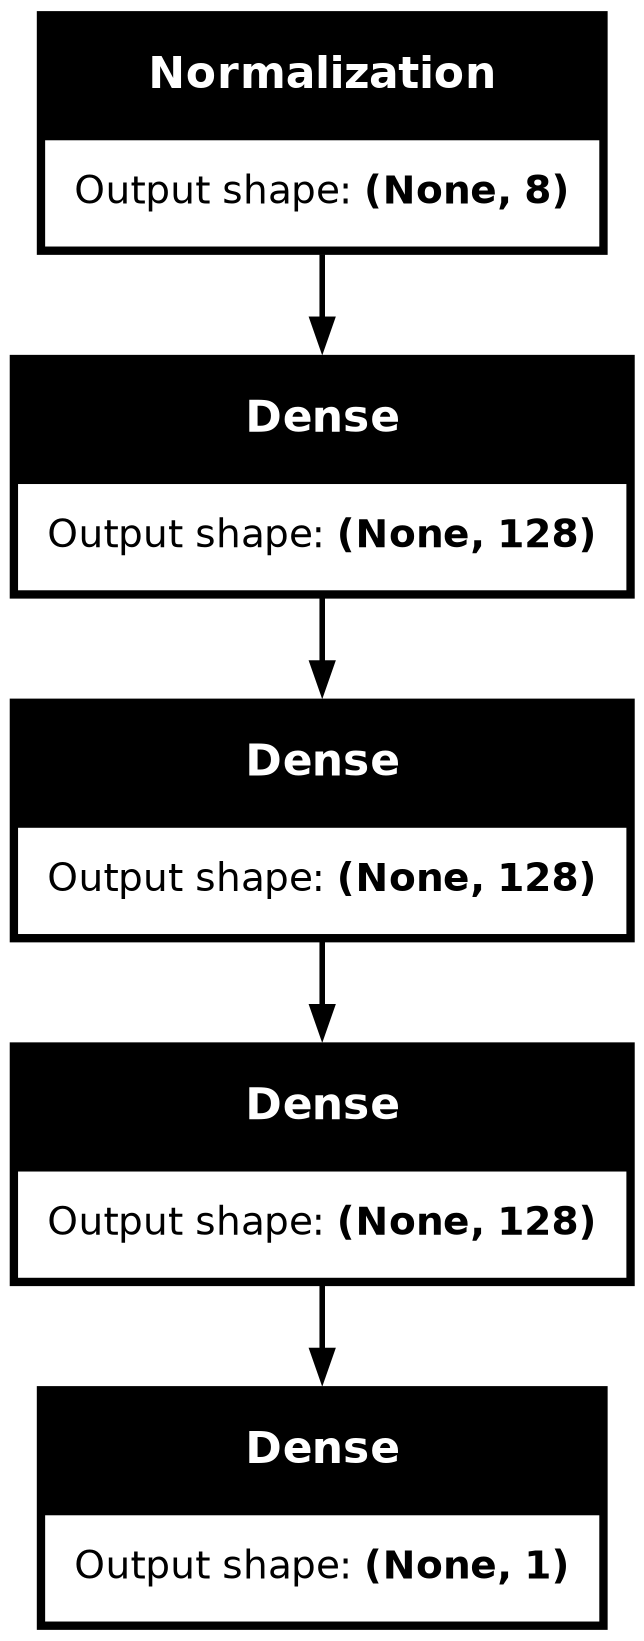

In [ ]:
tf.keras.utils.plot_model(model,to_file="mode.png",show_shapes=True)

# Model Compile

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.1),
    loss=MeanAbsoluteError(),
    metrics=[RootMeanSquaredError()]
)

In [ ]:
print(len(train_dataset))
print(len(val_dataset))

25
1


In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=100, verbose=1)

Epoch 1/100
22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 250284.0781 - root_mean_squared_error: 288708.3750

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("IteratorGetNext:0", shape=(None, None, 8), dtype=float32). Expected shape (None, 8), but input has incompatible shape (None, None, 8)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, None, 8), dtype=float32)
  • training=False
  • mask=None

In [ ]:
history.history

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','val_loss'])
plt.show()

In [ ]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model performance')
plt.xlabel('epoch')
plt.ylabel('rmse')
plt.legend(['Train','val'])
plt.show()

In [ ]:
model.evaluate(X_test,y_test)

In [ ]:
model.predict(tf.expand_dims(X_test[0],axis=0))

In [ ]:
y_test[0]

In [ ]:
y_true = list(y_test[:,0].numpy())

In [ ]:
y_pred = list(model.predict(X_test)[:,0])

In [ ]:
ind = np.arange(100)
plt.figure(figsize=(40,20))

width = 0.1

plt.bar(ind, y_pred, width, label='Predicted Car Price')
plt.bar(ind + width, y_true, width, label='Actual Car Price')

plt.xlabel('Actual vs Predicted Prices')
plt.ylabel('Car Price Prices')

plt.show()